In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import pickle
%matplotlib inline

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()
print(" I have a GPU? ", use_cuda)

 I have a GPU?  True


# Skip the data Pre-Processing 

### you already have the pickle files, just run the 2 cells below to collect the 3 pickle files that are the training data, they are just Lang Class instances with the word2index and index2word mappings and n_words for vocab size, the class Lang must be defined before the pickle and populate it with data. 

In [2]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# Maximum length of the sequences you are mapping 
MAX_LENGTH = 20 #50
MIN_LENGTH = 4 #2

# start of sentence and end of sentence indices
SOS_token = 0
EOS_token = 1

In [3]:
input_lang = pickle.load( open( "saved_pickle/input_lang_4_20.p", "rb" ) )
output_lang = pickle.load( open(  "saved_pickle/output_lang_4_20.p", "rb" ) )
pairs = pickle.load( open( "saved_pickle/pairs_4_20.p", "rb" ) )

# see the way it works

#input_lang.n_words, input_lang.word2index["froid"], input_lang.index2word[33]
output_lang.word2index["?"]

51

In [9]:
print("number of training examples",len(pairs))

number of training examples 525845


## Dont have to run these, the pre-processing from ../data folder/input-output.txt
 final outputs of the preprocessing steps, they are just Lang Class instances with the word2index and index2word mappings and n_words for vocab size, the class Lang must be defined before the pickle and populate it with data. 

In [4]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub("newlinechar", "", s)
    return s



def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('../data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs


def filterPair(p):
    '''
    Your Preferences here
    '''
    return len(p[0].split(' ')) < MAX_LENGTH and \
           len(p[1].split(' ')) < MAX_LENGTH and \
           len(p[1].split(' ')) > MIN_LENGTH and \
           "https://" not in p[1] 
        


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def prepareData(lang1, lang2, reverse=False, Filter = False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    if Filter:
        pairs = filterPairs(pairs)
        print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [53]:
#input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
#print(random.choice(pairs))
#input_lang.index2word[15] # input is french

#pickle.dump( input_lang, open( "saved_pickle/input_lang.p", "wb" ) )
#pickle.dump( output_lang, open( "saved_pickle/output_lang.p", "wb" ) )
#pickle.dump( pairs, open( "saved_pickle/pairs.p", "wb" ) )

input_lang, output_lang, pairs = prepareData('input', 'output', reverse=False, Filter = True)

Reading lines...
Read 622654 sentence pairs
Trimmed to 280811 sentence pairs
Counting words...
Counted words:
input 36663
output 38082


In [54]:
pickle.dump( input_lang, open( "saved_pickle/input_lang_4_20.p", "wb" ) )
pickle.dump( output_lang, open( "saved_pickle/output_lang_4_20.p", "wb" ) )
pickle.dump( pairs, open( "saved_pickle/pairs_4_20.p", "wb" ) )

# Start here after you have the pickle files, skip above

## Just some Helper functions used in the Main training loop and main model 

### Example training output

time elapsed, estimated time remaining given, and progress %, Loss

1m 52s (- 26m 10s) (5000 6%) 2.8937 

3m 40s (- 23m 50s) (10000 13%) 2.3437

5m 31s (- 22m 4s) (15000 20%) 2.0382

In [5]:

##############  Converts [" input string ", " output string "] (pair) , appends <EOS> index and returns indices ######

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def variableFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    if use_cuda:
        return result.cuda()
    else:
        return result


def variablesFromPair(pair):
    input_variable = variableFromSentence(input_lang, pair[0])
    target_variable = variableFromSentence(output_lang, pair[1])
    return (input_variable, target_variable)

######## the pair indices are returned as 2 LongTensor Variables in torch #############


######## Tells you how long youve been training and how much longer you have left ####

import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

######################################################################3

############### plot_losses #######################################

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    
####################################################################

## GRU - The Gated recurrent unit - FYI

Here is the way torch formulates each layer of the GRU

\begin{split}\begin{array}{ll}
r_t = \sigma(W_{ir} x_t + b_{ir} + W_{hr} h_{(t-1)} + b_{hr}) \\
z_t = \sigma(W_{iz} x_t + b_{iz} + W_{hz} h_{(t-1)} + b_{hz}) \\
n_t = \tanh(W_{in} x_t + b_{in} + r_t * (W_{hn} h_{(t-1)}+ b_{hn})) \\
h_t = (1 - z_t) * n_t + z_t * h_{(t-1)} \\
\end{array}\end{split}

where h_t is the hidden state at time t, x_t is the hidden state of the previous layer at time t or input_t for the first layer, and r_t, z_t, n_t are the reset, input, and new gates, respectively. σ is the sigmoid function

### Instantiation Parameters:	

input_size – The number of expected features in the input x 

hidden_size – The number of features in the hidden state h

num_layers – Number of recurrent layers.

bias – If False, then the layer does not use bias weights b_ih and b_hh. Default: True

batch_first – If True, then the input and output tensors are provided as (batch, seq, feature)

dropout – If non-zero, introduces a dropout layer on the outputs of each RNN layer except the last layer
p – probability of an element to be zeroed. Default: 0.5

bidirectional – If True, becomes a bidirectional RNN. Default: False


#### Inputs: input, h_0

input (seq_len, batch, input_size): tensor containing the features of the input sequence. The input can also be a packed variable length sequence. See torch.nn.utils.rnn.pack_padded_sequence() for details.

h_0 (num_layers * num_directions(2 for bidirectional), batch, hidden_size): tensor containing the initial hidden state for each element in the batch. Defaults to zero if not provided.

#### Outputs: output, h_n

output (seq_len, batch, hidden_size * num_directions): tensor containing the output features h_t from the last layer of the RNN, for each t. If a torch.nn.utils.rnn.PackedSequence has been given as the input, the output will also be a packed sequence.

h_n (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t=seq_len

# Encoder and Decoder in next 2 cells

### the class for these models needs to be defined to load parameters into them

In [6]:
class EncoderRNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers = 3, bidirectional = False):
        
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional 
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers, bidirectional=bidirectional)
        
        if bidirectional:
            num_directions = 2
        else:
            num_directions = 1
        
        # make the initial hidden state learnable as well 
        hidden0 = torch.zeros(self.num_layers*num_directions, 1, self.hidden_size)
        
        if use_cuda:
            hidden0 = hidden0.cuda()
        else:
            hidden0 = hidden0

        self.hidden0 = nn.Parameter(hidden0, requires_grad=True)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        
        if self.bidirectional:
            output = output[:, :, :self.hidden_size] + output[:, : ,self.hidden_size:] # Sum bidirectional outputs
            
        return output, hidden

    def initHidden(self):
        
        if use_cuda:
            return self.hidden0.cuda()
        else:
            return self.hidden0

In [7]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH, num_layers = 3):
        
        super(AttnDecoderRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.num_layers = num_layers

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size, num_layers = num_layers)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
        hidden0 = torch.zeros(self.num_layers, 1, self.hidden_size)
        
        if use_cuda:
            hidden0 = hidden0.cuda()
        else:
            hidden0 = hidden0

        self.hidden0 = nn.Parameter(hidden0, requires_grad=True)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        
        if use_cuda:
            return self.hidden0.cuda()
        else:
            return self.hidden0

# Training

## trainIters() takes the encoder instance, decoder instance and trains it using the helper function train()

In [8]:

def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer,
          criterion, max_length=MAX_LENGTH, teacher_forcing_ratio = 0.5, bidirectional = False):
    
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    loss = 0

    for ei in range(input_length):
        
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
        
        encoder_outputs[ei] = encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    
    if bidirectional:
        # sum the bidirectional hidden states into num_layers long cause the decoder is not bidirectional
        encoder_hidden = encoder_hidden[:encoder.num_layers, :, :] + encoder_hidden[encoder.num_layers:, : ,:] 
        
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):

            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]

            decoder_input = Variable(torch.LongTensor([[ni]]))
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input

            loss += criterion(decoder_output, target_variable[di])
            if ni == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.data[0] / target_length

In [20]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100,
               learning_rate=0.01, teacher_forcing_ratio = 0.5, bidirectional = False,
               name = "noname", lowest_loss =100, gamma = 0.95):
    
    
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    
    #encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    #decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    escheduler = optim.lr_scheduler.StepLR(encoder_optimizer, step_size=print_every, gamma=gamma) 
    dscheduler = optim.lr_scheduler.StepLR(decoder_optimizer, step_size=print_every, gamma=gamma) 
    
    training_pairs = [variablesFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    
    criterion = nn.NLLLoss()

    lowest_loss = lowest_loss
    
    for iter in range(1, n_iters + 1):
        
        escheduler.step()
        dscheduler.step()
        
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]

        loss = train(input_variable, target_variable, encoder, decoder, 
                     encoder_optimizer, decoder_optimizer, criterion, 
                     teacher_forcing_ratio = teacher_forcing_ratio,
                     bidirectional =  bidirectional)
        
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))
            
            if lowest_loss > print_loss_avg:
                lowest_loss = print_loss_avg
                print("new lowest loss, saving...")
                torch.save(encoder.state_dict(), "saved_params/encoder"+name+".pth")
                torch.save(attn_decoder.state_dict(), "saved_params/attn_decoder"+name+".pth")

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0


    showPlot(plot_losses)

# Instantiate The Encoder and Decoder 

### move the model to GPU 

In [13]:
hidden_size = 128#256
num_layers = 2#3
bidirectional = False#True
encoder = EncoderRNN(input_lang.n_words, hidden_size, num_layers = num_layers, bidirectional = bidirectional)
attn_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1, num_layers = num_layers)

if use_cuda:
    encoder = encoder.cuda()
    attn_decoder = attn_decoder.cuda()

## Run this cell if you have saved parameters you want to load into the encoder decoder

In [33]:
#encoder.load_state_dict(torch.load("saved_params/encoder.pth"))
#attn_decoder.load_state_dict(torch.load("saved_params/attn_decoder.pth"))
encoder.load_state_dict(torch.load("saved_params/encoder_2L_h128_uni3.pth"))
attn_decoder.load_state_dict(torch.load("saved_params/attn_decoder_2L_h128_uni3.pth"))

## call to the MAIN TRAINING LOOP and cell for storing parameters

In [ ]:
trainIters(encoder, attn_decoder, n_iters = 100000, print_every=10000, 
           learning_rate=0.001, teacher_forcing_ratio = 0.9,
           bidirectional = bidirectional, name = "_2L_h128_uni3",
           lowest_loss = 4.1, gamma = 0.95) # last loss 4.3393, 16 secs per 100 iters, so ~ 22500 iters/hr

7m 37s (- 68m 34s) (10000 10%) 4.9078
15m 2s (- 60m 9s) (20000 20%) 4.8423
22m 33s (- 52m 37s) (30000 30%) 4.7705


In [40]:
# If you want to save the results of your training
torch.save(encoder.state_dict(), "saved_params/encoder_2L_h128_uni3.pth")
torch.save(attn_decoder.state_dict(), "saved_params/attn_decoder_2L_h128_uni3.pth")

# Inference/Prediction/Chat with me

### evaluate() is your main inference function to deploy the encoder-decoder as a chatbot

### evaluateRandomly() calls evaluate() to give you a sampling of dialogue

In [36]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH,
             bidirectional =bidirectional):
    
    
    input_variable = variableFromSentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei],
                                                 encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))  # SOS
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    
    if bidirectional:
        # sum the bidirectional hidden states into num_layers long cause the decoder is not bidirectional
        encoder_hidden = encoder_hidden[:encoder.num_layers, :, :] + encoder_hidden[encoder.num_layers:, : ,:]

    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        decoder_attentions[di] = decoder_attention.data
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])

        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    return decoded_words, decoder_attentions[:di + 1]

def evaluateRandomly(encoder, decoder, n=10, bidirectional = False):
    for i in range(n):
        pair = random.choice(pairs)
        print('input from data >', pair[0])
        print('output from data=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0], bidirectional = bidirectional)
        output_sentence = ' '.join(output_words)
        print('bot response <', output_sentence)
        print('')

In [37]:
evaluateRandomly(encoder, attn_decoder,  n=10, bidirectional = bidirectional)

input from data > happy independence day .
output from data= yeah . happy fourth of july .
bot response < i m not going to . . . <EOS>

input from data > collision ? with what ?
output from data= the page s missing . then their sos was real .
bot response < i m not going to . . <EOS>

input from data > who is this ?
output from data= hello my name is barry egan and i called your service 
bot response < i don t know . <EOS>

input from data > oh yeah i love those . yeah . . . those are funny . . .
output from data= well it was really nice meeting you and uh . . . i d better get a cab .
bot response < i don t know . <EOS>

input from data > cigarettes and beer rule ! huh huh .
output from data= yeah ! we re with the bureau of cigarettes and chicks ! we re gonna score !
bot response < i m not going to . . <EOS>

input from data > is that bad ?
output from data= not at all . those are our honeymoon suites .
bot response < i don t know . <EOS>

input from data > let s hope you make the most

input = what does this mean where are we and where are we going ?
output = i m going to be . <EOS>


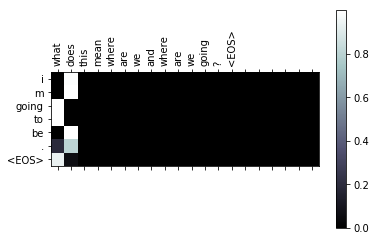

input = why is this happening ?
output = i don t know . <EOS>


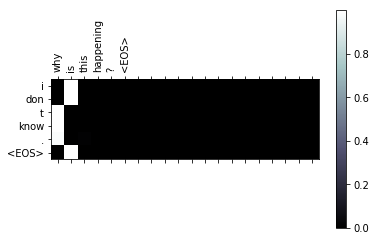

input = well me something stupid
output = i m not going to . . <EOS>


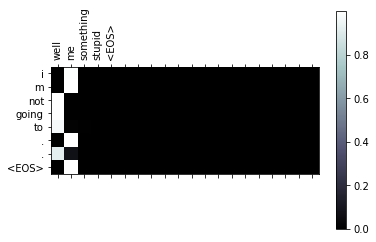

input = you can make it if you try
output = i m not going to . . <EOS>


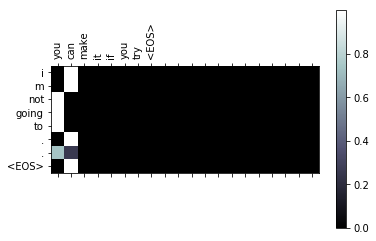

In [38]:
bidirectional = False #True

def showAttention(input_sentence, output_words, attentions, bidirectional = False):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence,encoder, attn_decoder, bidirectional = False):
    
    output_words, attentions = evaluate(encoder, attn_decoder, input_sentence, bidirectional = bidirectional)
    
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("what does this mean where are we and where are we going ?",
                         encoder, attn_decoder, bidirectional = bidirectional  )

evaluateAndShowAttention("why is this happening ?",encoder, attn_decoder, bidirectional = bidirectional)

evaluateAndShowAttention("tell me something stupid",encoder, attn_decoder, bidirectional = bidirectional)

evaluateAndShowAttention("you can make it if you try",encoder, attn_decoder, bidirectional = bidirectional)

# Reinforcement Learning

In [ ]:
#### TO DO: ####

##############